In [9]:
import numpy as np
import matplotlib.pyplot as plt
import ann
    %matplotlib inline

        

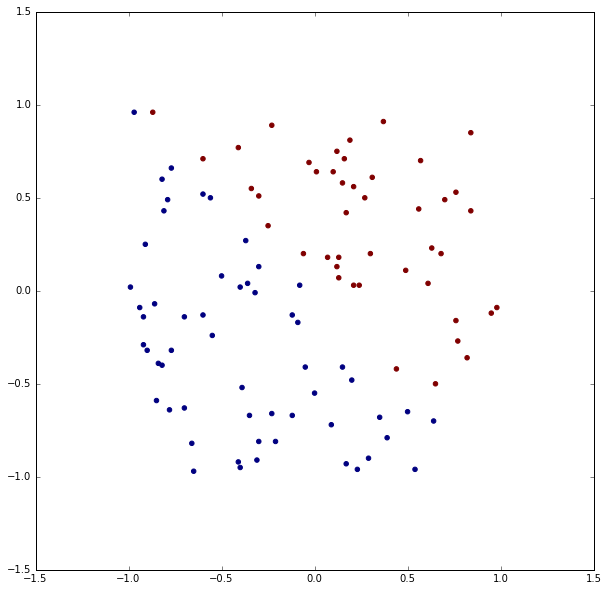

In [10]:
# Now we generate some synthetic data
np.random.seed(10)

N = 100
X = np.round(np.random.rand(N, 2) * 2 - 1, decimals=2)
y = np.zeros((N, 1))

for i, x in enumerate(X):
    if np.sum(x) > 0:
        y[i][0] = 1
        
np.sum(y, axis=0)


X.reshape(X.size)
X.shape
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], c=y[:, 0], edgecolors='face')

In [11]:
np.random.seed(10)
nn = ann.NewNeuralNet(2, 1)

np.random.seed(20)
#print(nn.compute_cost(X, y))

x_sample = X[0].reshape(1, 2)
y_sample = y[0]

print("numeric_gradients", nn.numeric_gradients(x_sample, y_sample))
backprop_gradients = nn.backprop_gradients(x_sample, y_sample)
print("backprop_gradients", backprop_gradients)

#print("numeric_gradients", nn.numeric_gradients(x_sample, y_sample))

print("params", nn._layers[0].params())
print("x_sample", x_sample)
print(nn.compute(x_sample))

original_cost = nn.compute_cost(x_sample, y_sample)
print(original_cost)

d = 0.0001
nn._layers[0]._params[0][0] += d
n0_cost = nn.compute_cost(x_sample, y_sample)
nn._layers[0]._params[0][0] -= d

nn._layers[0]._params[1][0] += d
n1_cost = nn.compute_cost(x_sample, y_sample)
nn._layers[0]._params[1][0] -= d

nn._layers[0]._params[2][0] += d
n2_cost = nn.compute_cost(x_sample, y_sample)
nn._layers[0]._params[2][0] -= d

print(n0_cost - original_cost, n1_cost-original_cost, n2_cost-original_cost)


numeric_gradients [array([ 0.91540268,  0.49431745, -0.87878658]), array([], dtype=float64)]
backprop_gradients [array([[ 0.45770134],
       [ 0.24715872],
       [-0.43939329]]), array([], dtype=float64)]
params [[ 0.38]
 [-0.68]
 [ 0.19]]
x_sample [[ 0.54 -0.96]]
[[ 0.45770134]]
0.611938399551
4.57713752449e-05 2.47162343531e-05 -4.39381850678e-05


In [12]:
np.random.seed(10)

nn = ann.NewNeuralNet(2, 3, 1)
print(nn.compute_cost(X, y))
print(X.shape)
learning_rate = 0.1
np.random.seed(20)
for i in range(1000):
    sample_i = np.random.randint(0, len(y))
    x_sample = X[sample_i]
    y_sample = y[sample_i]
    gradients = nn.backprop_gradients(x_sample, y_sample)
    gradients[0] *= learning_rate
    nn.update_params(gradients)
    
print(nn.compute_cost(X, y))

0.668575734234
(100, 2)
0.0577997114313
